In [81]:
import numpy as np
import pandas as  pd
import tensorflow as tf
from tensorflow import keras
#import keras
import matplotlib.pyplot as plt 
from tensorflow.keras import layers
from sklearn import *
import math
from sklearn.preprocessing import OrdinalEncoder
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split


## Import Data


In [82]:
#load the dataset
data = load_boston()
#convert the dataset into a Pandas dataframe and add the target column named 'Price'
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Price'] = data.target


In [83]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [84]:
#One-Hot Encode the CHAS column
df = pd.get_dummies(df, columns=['CHAS'], drop_first=True)
#define the features and the labels, X and y
X = df.drop(['Price'], axis=1)
y = df['Price']

In [85]:
#split the features and labels into  train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)


In [86]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, shuffle=True)

In [87]:
from sklearn.preprocessing import RobustScaler

#rescale the data to be robust to outliers
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [88]:
X_train.shape

(303, 13)


## Create a sampling layer


In [89]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # Parametrization trick
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon 

## Build the encoder


In [90]:
latent_dim = 3 # Latent Space dimension on the bottleneck
input_dim = X_train.shape[1]
Leaky_ReLu = keras.layers.LeakyReLU(alpha=0.01)

encoder_inputs = keras.Input(shape=( input_dim, ))
x = layers.Dense(5, activation=Leaky_ReLu)(encoder_inputs)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 5)            70          ['input_6[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 3)            18          ['dense_8[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 3)            18          ['dense_8[0][0]']                
                                                                                            

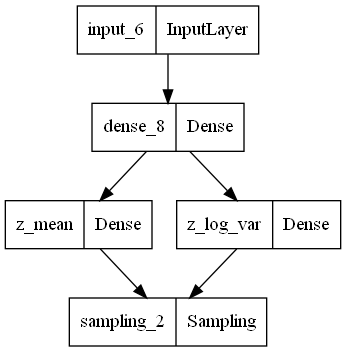

In [91]:
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(encoder, to_file='encoder.png')

## Build the decoder


In [92]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(3,  activation=Leaky_ReLu)(latent_inputs)
decoder_outputs = layers.Dense(1, activation="linear")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 12        
                                                                 
 dense_10 (Dense)            (None, 1)                 4         
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


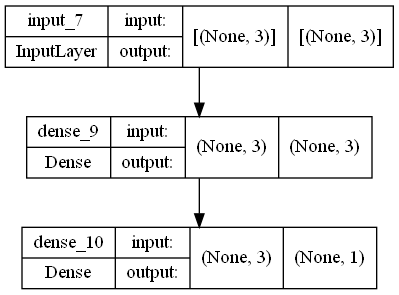

In [93]:
plot_model(decoder,  show_shapes=True, show_layer_names=True)

## Define the VAE as a Model with a custom train_step


In [94]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, KL_hyperparam, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.KL_hyperparam = KL_hyperparam
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")  #MEAN? 
        self.reconstruction_loss_tracker = keras.metrics.Mean(    #MEAN? 
            name="MSE"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")   #MEAN? 
        
        self.total_loss_tracker_val = keras.metrics.Mean(name="total_loss_val")  #MEAN? 
        self.reconstruction_loss_tracker_val = keras.metrics.Mean(    #MEAN? 
            name="MSE_val"
        )
        self.kl_loss_tracker_val = keras.metrics.Mean(name="kl_loss_val")   #MEAN? 

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            
            self.total_loss_tracker_val,
            self.reconstruction_loss_tracker_val,
            self.kl_loss_tracker_val
        ]

    def train_step(self, data):
        x, y_true = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = keras.losses.mean_squared_error(y_true, reconstruction)
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            #kl_loss = tf.reduce_mean(kl_loss, axis=1)
            
            total_loss = reconstruction_loss + kl_loss * self.KL_hyperparam
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "MSE": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # Unpack the data
        x, y_true = data
        # Compute predictions
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        
        ## Losses
        reconstruction_loss = keras.losses.mean_squared_error(y_true, reconstruction)
        
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss * self.KL_hyperparam

        # Updates the metrics tracking the loss
        self.total_loss_tracker_val.update_state(total_loss)
        
        self.reconstruction_loss_tracker_val.update_state(reconstruction_loss)
        
        self.kl_loss_tracker_val.update_state(kl_loss)
        
        return {
            "loss_val": self.total_loss_tracker_val.result(),
            "MSE_val": self.reconstruction_loss_tracker_val.result(),
            "kl_loss_val": self.kl_loss_tracker_val.result(),
        }



    def call(self, inputs):

        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
                


        return reconstruction
    


## Train the VAE

In [105]:
vae = VAE(encoder, decoder, 1)

In [106]:
from keras.optimizers import adam_v2
adam = adam_v2.Adam()




In [107]:
vae.compile(optimizer=adam)

In [108]:
history = vae.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=80, batch_size=8 )

Epoch 1/80
38/38 [==============================] - 1s 4ms/step - loss: 24.3643 - MSE: 15.6290 - kl_loss: 8.8815 - val_loss_val: 29.4287 - val_MSE_val: 21.0458 - val_kl_loss_val: 8.5130
Epoch 2/80
38/38 [==============================] - 0s 2ms/step - loss: 28.0121 - MSE: 13.8180 - kl_loss: 8.9553 - val_loss_val: 28.5432 - val_MSE_val: 20.4931 - val_kl_loss_val: 8.1774
Epoch 3/80
38/38 [==============================] - 0s 2ms/step - loss: 27.2055 - MSE: 14.4819 - kl_loss: 8.8903 - val_loss_val: 29.6095 - val_MSE_val: 21.4405 - val_kl_loss_val: 8.3003
Epoch 4/80
38/38 [==============================] - 0s 3ms/step - loss: 22.5617 - MSE: 16.4124 - kl_loss: 8.8596 - val_loss_val: 28.9185 - val_MSE_val: 20.5482 - val_kl_loss_val: 8.5012
Epoch 5/80
38/38 [==============================] - 0s 2ms/step - loss: 23.5842 - MSE: 14.2782 - kl_loss: 9.0747 - val_loss_val: 28.3089 - val_MSE_val: 20.1252 - val_kl_loss_val: 8.3139
Epoch 6/80
38/38 [==============================] - 0s 2ms/step - loss

Epoch 45/80
38/38 [==============================] - 0s 2ms/step - loss: 18.4641 - MSE: 14.6565 - kl_loss: 8.1447 - val_loss_val: 28.8138 - val_MSE_val: 21.2330 - val_kl_loss_val: 7.6997
Epoch 46/80
38/38 [==============================] - 0s 2ms/step - loss: 20.4962 - MSE: 14.1001 - kl_loss: 8.1906 - val_loss_val: 27.3798 - val_MSE_val: 19.8573 - val_kl_loss_val: 7.6389
Epoch 47/80
38/38 [==============================] - 0s 2ms/step - loss: 21.7684 - MSE: 13.5546 - kl_loss: 8.0835 - val_loss_val: 28.4508 - val_MSE_val: 20.9000 - val_kl_loss_val: 7.6656
Epoch 48/80
38/38 [==============================] - 0s 3ms/step - loss: 20.7466 - MSE: 13.9079 - kl_loss: 8.0658 - val_loss_val: 28.8376 - val_MSE_val: 21.2442 - val_kl_loss_val: 7.7089
Epoch 49/80
38/38 [==============================] - 0s 2ms/step - loss: 22.3527 - MSE: 13.9470 - kl_loss: 8.1625 - val_loss_val: 28.1941 - val_MSE_val: 20.6821 - val_kl_loss_val: 7.6262
Epoch 50/80
38/38 [==============================] - 0s 2ms/step 

In [109]:
print(history.history.keys())

dict_keys(['loss', 'MSE', 'kl_loss', 'val_loss_val', 'val_MSE_val', 'val_kl_loss_val'])


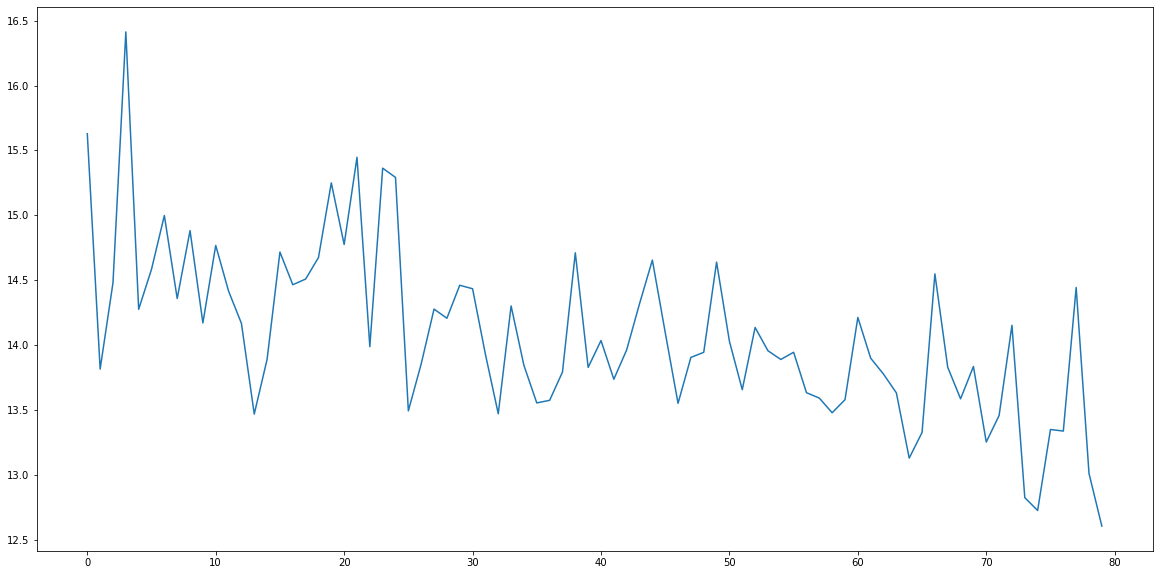

In [110]:
plt.plot(history.history['MSE'])


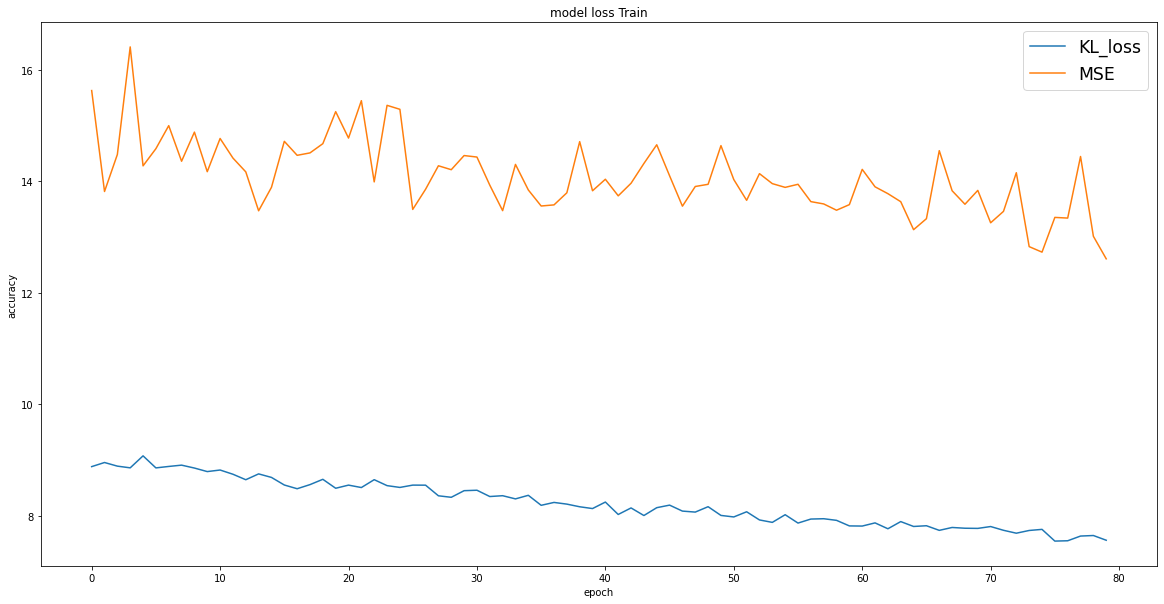

In [111]:
plt.plot(history.history['kl_loss'])
#plt.plot(history.history['val_total_loss'])
plt.title('model loss Train')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['MSE'])
plt.legend(['KL_loss', 'MSE'], loc='upper right', fontsize ='xx-large')
plt.show()


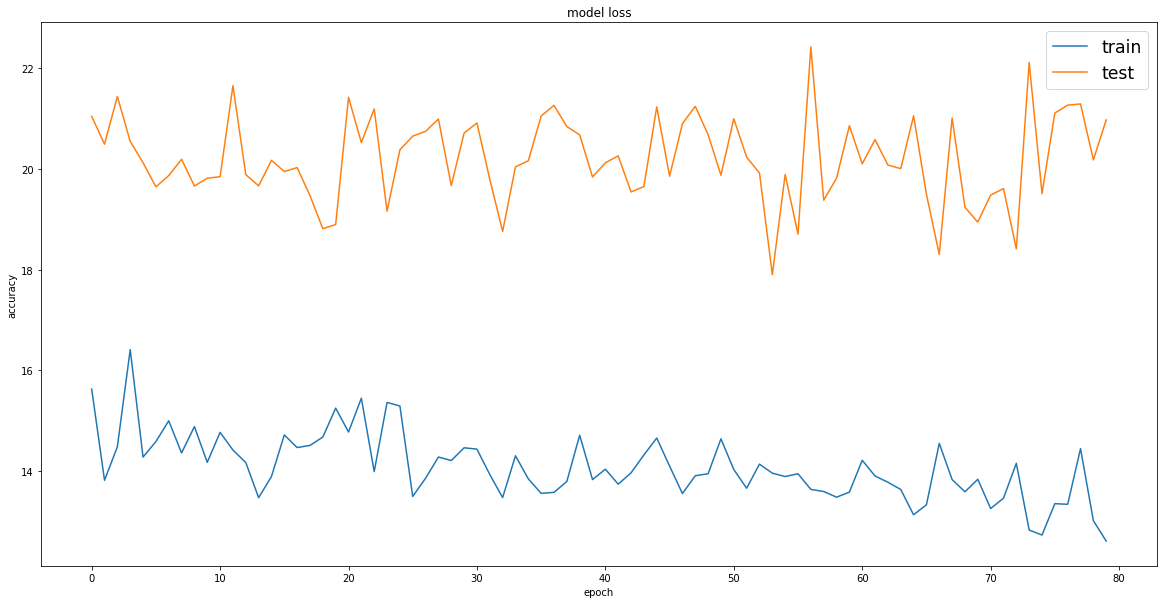

In [112]:
# summarize history for accuracy
plt.plot(history.history['MSE'])
#plt.plot(history.history['val_total_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['val_MSE_val'])

plt.legend(['train', 'test'], loc='upper right', fontsize ='xx-large')
plt.show()


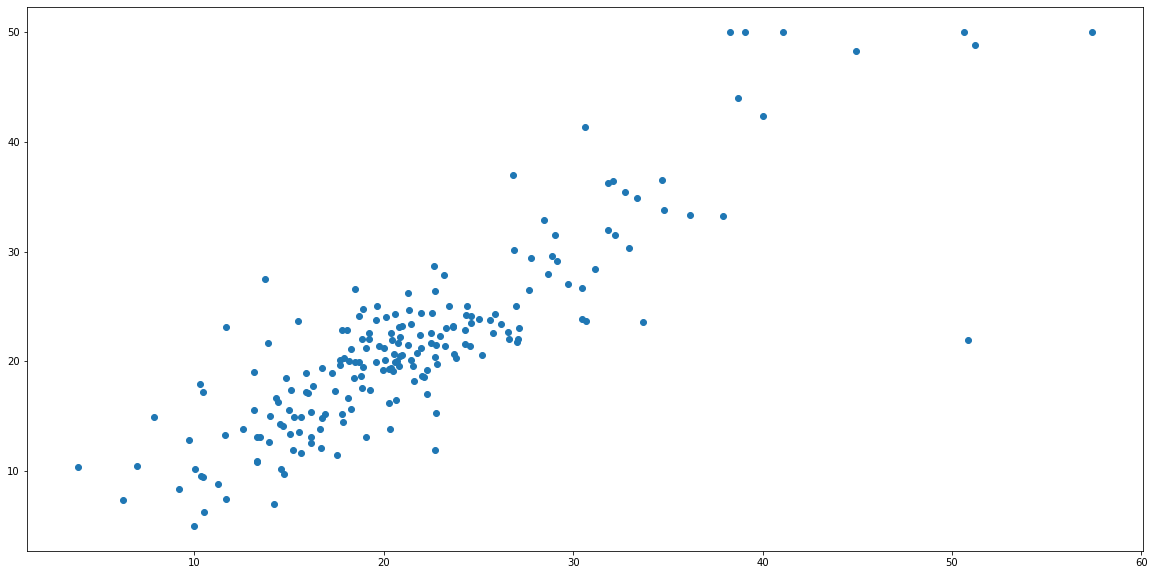

In [113]:
plt.scatter(vae.predict(X_test)[:], y_test[:])

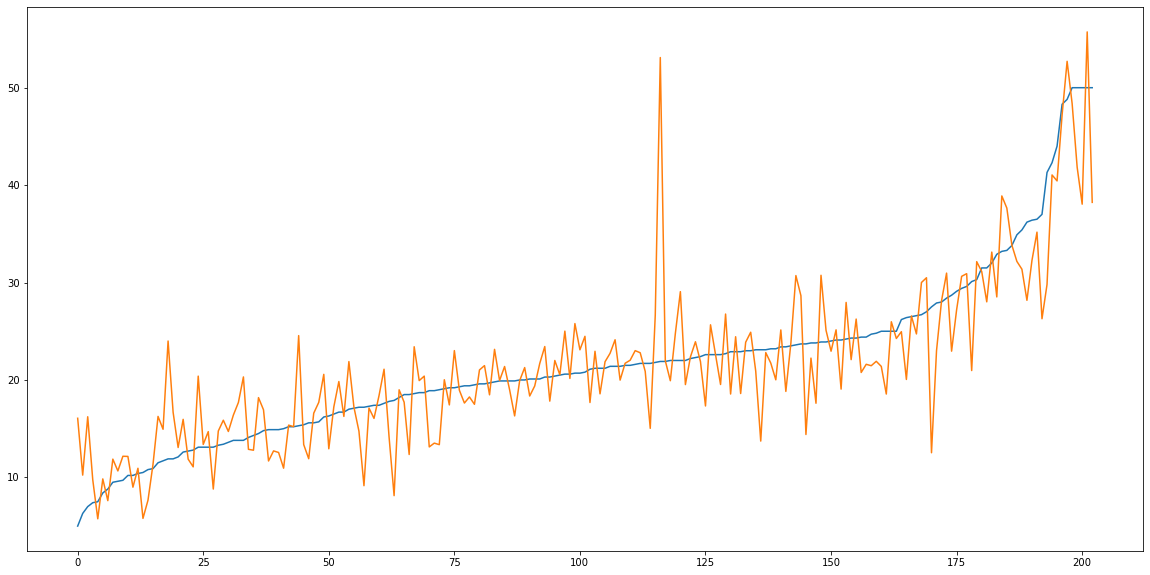

In [115]:
plt.plot(np.sort(y_test))

plt.plot(vae.predict(X_test)[np.argsort(y_test)])